In [18]:
from typing import Any
import pennylane as qml
from pennylane import numpy as np # Must import numpy from pennylane.

In [27]:
from typing import Iterable, Iterator
from pennylane.operation import Operator
from pennylane.measurements import MeasurementProcess

def flatten_to_operations_or_measurements(root: Any) -> Iterator[Operator | MeasurementProcess]:
    """Helper function which flattens nested lists of PennyLane operations and measurements into a single-dimensional iterator."""
    # Yield operator or measurement.
    if isinstance(root, (Operator, MeasurementProcess)):
        yield root
    # Recursively yield sub-contents from nested iterables (except strings).
    elif isinstance(root, Iterable) and not isinstance(root, str):
        for subtree in root:
            yield from flatten_to_operations_or_measurements(subtree)
    # Unsupported type.
    else:
        raise TypeError(f'Not a PennyLane operation, measurement, or typing Iterable: {type(root)} {root}')


def apply_gen(ops: Operator | MeasurementProcess | Iterable[Operator | MeasurementProcess]):
    """Recursively adds """
    for op in flatten_to_operations_or_measurements(ops):
        qml.apply(op)

In [26]:
list(flatten_to_operations_or_measurements([qml.Hadamard(0), [qml.Hadamard(1), qml.Hadamard(2)], [qml.expval(qml.PauliZ(0))], [qml.Hadamard(3)]]))

[Hadamard(wires=[0]),
 Hadamard(wires=[1]),
 Hadamard(wires=[2]),
 expval(PauliZ(wires=[0])),
 Hadamard(wires=[3])]

In [ ]:
qml.expval()

In [73]:
from typing import Callable, Sequence

In [75]:
def entangle_agents_phi_plus(wires: list, d: int, n: int):
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_phi_minus(wires: list, d: int, n: int):
    """Entangles via $\\Phi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_psi_plus(wires: list, d: int, n: int):
    """Entangles via $\\Psi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])
            

def entangle_agents_psi_minus(wires: list, d: int, n: int):
    """Entangles via $\\Psi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


In [74]:
## Adapted from: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning

def variational_rotation_3(wire: int, symbols: tuple[float, float, float]):
    """Applies 3 rotation gates (Rx, Ry, Rz) to a single qubit using provided symbols for parameterization."""
    qml.RX(phi=symbols[0], wires=wire)
    qml.RY(phi=symbols[1], wires=wire)
    qml.RZ(phi=symbols[2], wires=wire)


def variational_rotation_layer(
    wires: list,
    symbols: list[list[float]],
    variational_rotation_fn: Callable[[int, list[float]], Any] = variational_rotation_3,
    ):
    for i, wire in enumerate(wires):
        variational_rotation_fn(wire, symbols[i])


def circular_entangling_layer(
    wires: list,
    gate: Callable[[Sequence[int]], Any] = qml.CZ,
    ):
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    for w0, w1 in zip(wires, wires[1:]):
        gate(w0, w1)
    if len(wires) != 2:
        gate(wires=[wires[0], wires[-1]]) # Entangle the first and last qubit.


def neighbor_entangling_layer(
    wires: list,
    gate: Callable[[tuple[int, int]], Any] = qml.CNOT,
    ):
    """Entangles a list of qubits with their next-neighbor (does not entangle first and last qubit)."""
    for w0, w1 in zip(wires, wires[1:]):
        gate(wires=[w0, w1])


def single_rotation_encoding_layer(
    wires: list,
    symbols: list[float],
    gate: Callable[[float, Sequence[int]], Any] = qml.RX,
    ) -> Any:
    for i, wire in enumerate(wires):
        gate(symbols[i], wire)

In [76]:
def dynamic_circuit_builder(wires: list, circuit_fn: Callable[..., MeasurementProcess|list[MeasurementProcess]]):
    """Allows building circuits dynamically based on the number of wires.
    
    Requires a list of wires and callback function to build the circuit where the first argument must be the same list of wires.
    """
    def wrapper(*args, **kwargs):
        return circuit_fn(wires, *args, **kwargs)
    return wrapper

(<Figure size 700x500 with 1 Axes>, <Axes: >)

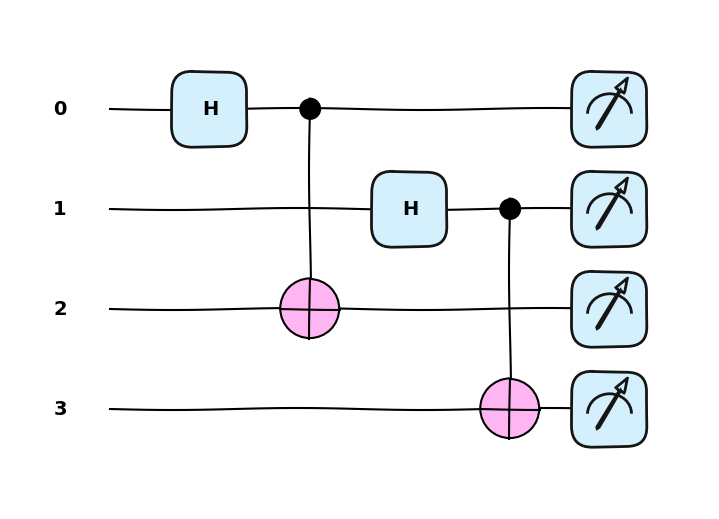

In [77]:
def circuit(wires: list, d: int, n: int):
    entangle_agents_phi_plus(wires=wires, d=d, n=n)
    return qml.state()


d = 2
n = 2
n_wires = d * n
wires = list(range(n_wires))
dev = qml.device('default.qubit', wires=n_wires)
circuit_fn = dynamic_circuit_builder(wires=wires, circuit_fn=circuit)
node = qml.QNode(circuit_fn, dev)


qml.draw_mpl(node, wire_order=wires, style="pennylane")(d=d, n=n)
# node(d=d, n=n)

In [78]:
import sympy

(<Figure size 800x700 with 1 Axes>, <Axes: >)

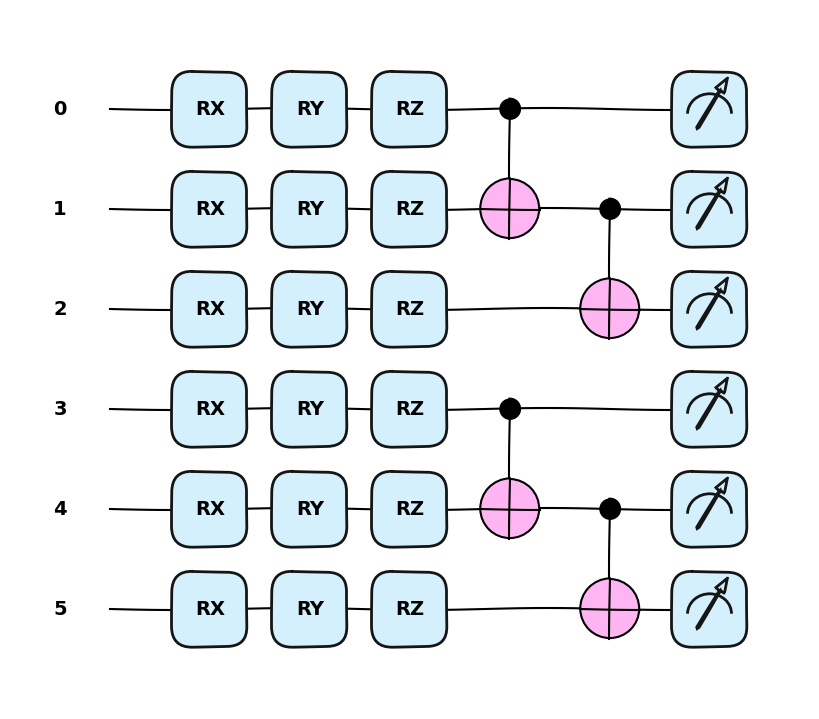

In [92]:
def parameterized_variational_policy_circuit(
    wires: list,
    n_layers: int,
    n_var_rotations: int = 3, # Number of rotational gates to apply for each qubit in the variational layer (e.g., Rx, Ry, Rz).
    variational_layer_fn: Callable[[list[int], list[list[float]]], Any] = variational_rotation_layer,
    entangling_layer_fn: Callable[[list[int]], Any] = lambda wires: neighbor_entangling_layer(wires, gate=qml.CNOT),
    symbol_superscript_index: int = None
    ) -> tuple[Callable[[], Iterable[Any]], list[list]]:
    d = len(wires) # Dimension of qubits.
    
    # Variational parameters.
    var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))

    # Define generator to build circuit.
    # This allows the caller to define circuit parameters.
    def gen_circuit():
        for l in range(n_layers):
            variational_layer_fn(wires, var_thetas[l])
            entangling_layer_fn(wires)

    return gen_circuit, (var_thetas.flatten().tolist(),)




def circuit(wires: list, d: int, n: int, n_layers: int):
    # entangle_agents_phi_plus(wires=wires, d=d, n=n)
    
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        
        # Policy circuit.
        agent_circuit_gen_fn, _ = parameterized_variational_policy_circuit(wires=wires[qidx:qidx+d], n_layers=n_layers, symbol_superscript_index=aidx)
        # symbol_list.append(agent_symbol_list) # Preserve symbols for agent.
        # circuit.append(agent_circuit_gen_fn())
        agent_circuit_gen_fn()
    
    # gen_circuit, _ = parameterized_variational_policy_circuit(wires=wires, **kwargs)
    # gen_circuit()
    return qml.state()

d = 3
n = 2
n_wires = d * n
wires = list(range(n_wires))
dev = qml.device('default.qubit', wires=n_wires)
circuit_fn = dynamic_circuit_builder(wires=wires, circuit_fn=circuit)
node = qml.QNode(circuit_fn, dev)


qml.draw_mpl(node, wire_order=wires, style="pennylane")(d=d, n=n, n_layers=1)
# node(d=d, n=n)

In [93]:
qml.matrix(node)(d=d, n=n, n_layers=1)

DecompositionUndefinedError: 